In [1]:
%pwd

'C:\\Users\\akhte\\Desktop\\Deep Learning Analytics\\Final Project'

In [2]:
import sys
sys.path.append('C:/Users/akhte/AppData/Local/Programs/Python/Python36/Lib/site-packages')

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import io
import pymongo
import bson                       # this is installed with the pymongo package
from skimage.data import imread   # or, whatever image library you prefer
import multiprocessing as mp      # will come in handy due to the size of the data

In [4]:
import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.constraints import maxnorm
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('tf')

Using TensorFlow backend.


In [5]:
import os, sys, math
import multiprocessing as mp
import struct

%matplotlib inline
import matplotlib.pyplot as plt

from collections import defaultdict
from tqdm import *

In [6]:
keras.__version__, tf.__version__

('2.1.1', '1.4.0')

In [7]:
#Data Processing

data = bson.decode_file_iter(open('C:/Users/akhte/Desktop/Deep Learning Analytics/Final Project/CDiscount/train_example.bson', 'rb'))

prod_to_category = dict()

for c, d in enumerate(data):
    product_id = d['_id']
    category_id = d['category_id'] # This won't be in Test data
    prod_to_category[product_id] = category_id
    for e, pic in enumerate(d['imgs']):
        picture = imread(io.BytesIO(pic['picture']))
        # do something with the picture, etc

prod_to_category = pd.DataFrame.from_dict(prod_to_category, orient='index')
prod_to_category.index.name = '_id'
prod_to_category.rename(columns={0: 'category_id'}, inplace=True)

In [8]:
prod_to_category.head()

,category_id
_id,
0,1000010653
1,1000010653
2,1000004079
3,1000004141
4,1000015539


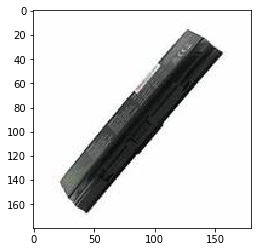

In [9]:
plt.imshow(picture);

In [10]:
from subprocess import check_output
data = bson.decode_file_iter(open('C:/Users/akhte/Desktop/Deep Learning Analytics/Final Project/CDiscount/train_example.bson', 'rb'))

#The number of pixel in each image (180x180x3) is setted as the pixel value of the affilated image
df=pd.DataFrame({"category":[]})
df=pd.concat([df,pd.DataFrame(columns=[i for i in range(180*180*3)])])
df['category'].astype('object')
index=0
pd.options.display.precision=11

for i,j in enumerate(data):
    for k in range(len(j['imgs'])):
        image=np.reshape((imread(io.BytesIO(j['imgs'][k]['picture']))),-1)
        image=image.tolist()
        image.insert(0,j["category_id"])
        df.loc[index]=image
        index=index+1    
            
        
df.to_csv("train_example.csv",index=False)
# Any results you write to the current directory are saved as output.

In [11]:
print(df.head(10))

       category    0    1    2    3    4    5    6    7    8  ...  97190  \
0  1000010653.0  255  255  255  255  255  255  255  255  255  ...    255   
1  1000010653.0  255  255  255  255  255  255  255  255  255  ...    255   
2  1000004079.0  254  254  254  254  254  254  254  254  254  ...    254   
3  1000004141.0  255  255  255  255  255  255  255  255  255  ...    255   
4  1000015539.0  255  255  255  255  255  255  255  255  255  ...    237   
5  1000010653.0  255  255  255  255  255  255  255  255  255  ...    255   
6  1000005744.0  255  255  255  255  255  255  255  255  255  ...    255   
7  1000004079.0  255  255  255  255  255  255  255  255  255  ...    255   
8  1000010667.0  255  255  255  255  255  255  255  255  255  ...    255   
9  1000018290.0  255  251  251  255  253  255  255  254  255  ...    253   

  97191 97192 97193 97194 97195 97196 97197 97198 97199  
0   255   255   255   255   255   255   255   255   255  
1   255   255   255   255   255   255   255   2

In [12]:
INPUT_PATH = os.path.join('C:/Users/akhte/Desktop/Deep Learning Analytics/Final Project/CDiscount')
CATEGORY_NAMES_DF = pd.read_csv(os.path.join(INPUT_PATH, 'category_names.csv'))
TRAIN_DB = bson.decode_file_iter(open(os.path.join(INPUT_PATH, 'train.bson'), 'rb'))
TRAIN_EXAMPLE_DB = bson.decode_file_iter(open(os.path.join(INPUT_PATH, 'train_example.bson'), 'rb'))
TEST_DB = bson.decode_file_iter(open(os.path.join(INPUT_PATH, 'test.bson'), 'rb'))

In [13]:
CATEGORY_NAMES_DF.head(5)

,category_id,category_level1,category_level2,category_level3
0,1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA
1,1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR
2,1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO
3,1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU
4,1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR


In [14]:
for item in TRAIN_DB:
    break
print(type(item))
print(item.keys())
print(item['_id'], item['category_id'], type(item['imgs']), len(item['imgs']))

<class 'dict'>
dict_keys(['_id', 'imgs', 'category_id'])
0 1000010653 <class 'list'> 1


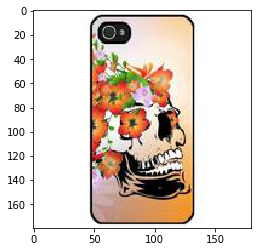

In [15]:
#Displaying a sample image
for e, pic in enumerate(item['imgs']):
    picture = imread(io.BytesIO(pic['picture']))
    plt.imshow(picture)
    plt.show()

In [16]:
level_tags = CATEGORY_NAMES_DF.columns[2:]
CATEGORY_NAMES_DF[CATEGORY_NAMES_DF['category_id'] == item['category_id']][level_tags]

,category_level2,category_level3
5055,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE


In [17]:
# Explore categories and finding their unique count in each level
print("Number of categories %i"% CATEGORY_NAMES_DF.category_id.nunique())
print("Number of level 1 categories %i"% CATEGORY_NAMES_DF.category_level1.nunique())
print("Number of level 2 categories %i"% CATEGORY_NAMES_DF.category_level2.nunique())
print("Number of level 3 categories %i"% CATEGORY_NAMES_DF.category_level3.nunique())

Number of categories 5270
Number of level 1 categories 49
Number of level 2 categories 483
Number of level 3 categories 5263


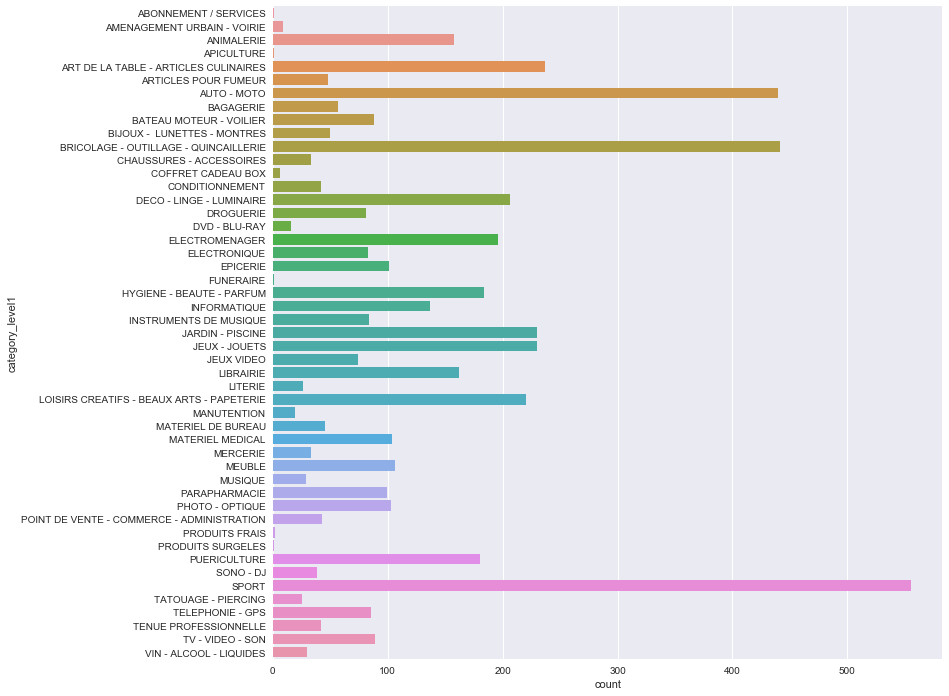

In [18]:
import seaborn as sns

#Exploring level 1 categories as Histogram
plt.figure(figsize=(12,12))
sns.countplot(y=CATEGORY_NAMES_DF.category_level1)
plt.show()

In [19]:
#Creating dataframe with training table_id and category_id
num_dicts = 7069896
prod_to_category = [None] * num_dicts
TRAIN_DB = bson.decode_file_iter(open(os.path.join(INPUT_PATH, 'train.bson'), 'rb'))

with tqdm_notebook(total=num_dicts) as bar:
    for i, item in enumerate(TRAIN_DB):
        bar.update()
        prod_to_category[i] = (item['_id'],item['category_id'])

In [20]:
TRAIN_CATEGORIES_DF = pd.DataFrame(prod_to_category, columns=['_id', 'category_id'])
TRAIN_CATEGORIES_DF.head()

,_id,category_id
0,0,1000010653
1,1,1000010653
2,2,1000004079
3,3,1000004141
4,4,1000015539


In [21]:
#Dataframe with all product ids, category_ids and category levels
TRAIN_DF = pd.merge(TRAIN_CATEGORIES_DF, CATEGORY_NAMES_DF, on = ['category_id'])
TRAIN_DF.head(5)

,_id,category_id,category_level1,category_level2,category_level3
0,0,1000010653,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE
1,1,1000010653,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE
2,5,1000010653,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE
3,11,1000010653,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE
4,16,1000010653,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE


In [22]:
# Making sure that we dont lose products while merging
TRAIN_DF._id.unique().sort() == TRAIN_CATEGORIES_DF._id.unique().sort()

True

In [23]:
###########################################################################################################
#To perform data preprocessing, data augmentation and neural network model, I formulated 2 approaches
###########################################################################################################

#Approach 1 
import os, sys, math, io
import numpy as np
import pandas as pd
import multiprocessing as mp
import bson
import struct

%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

from collections import defaultdict
from tqdm import *

In [24]:
data_dir = "C:/Users/akhte/Desktop/Deep Learning Analytics/Final Project/CDiscount/"

train_bson_path = os.path.join(data_dir, "train.bson")
num_train_products = 7069896

# train_bson_path = os.path.join(data_dir, "train_example.bson")
# num_train_products = 82

test_bson_path = os.path.join(data_dir, "test.bson")
num_test_products = 1768182

In [25]:
categories_path = os.path.join(data_dir, "category_names.csv")
categories_df = pd.read_csv(categories_path, index_col="category_id")

# Maps the category_id to an integer index
categories_df["category_idx"] = pd.Series(range(len(categories_df)), index=categories_df.index)

categories_df.to_csv("categories.csv")
categories_df.head()

,category_level1,category_level2,category_level3,category_idx
category_id,,,,
1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,0
1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR,1
1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO,2
1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU,3
1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR,4


In [26]:
def make_category_tables():
    cat2idx = {}
    idx2cat = {}
    for ir in categories_df.itertuples():
        category_id = ir[0]
        category_idx = ir[4]
        cat2idx[category_id] = category_idx
        idx2cat[category_idx] = category_id
    return cat2idx, idx2cat

In [27]:
cat2idx, idx2cat = make_category_tables()
# Checking...
cat2idx[1000012755], idx2cat[4]

(4, 1000012755)

In [28]:
#This function reads through the BSON format data and returns a tabular form product id, category id anc classifier level lists
def read_bson(bson_path, num_records, with_categories):
    rows = {}
    with open(bson_path, "rb") as f, tqdm(total=num_records) as pbar:
        offset = 0
        while True:
            item_length_bytes = f.read(4)
            if len(item_length_bytes) == 0:
                break

            length = struct.unpack("<i", item_length_bytes)[0]

            f.seek(offset)
            item_data = f.read(length)
            assert len(item_data) == length

            item = bson.BSON.decode(item_data)
            product_id = item["_id"]
            num_imgs = len(item["imgs"])

            row = [num_imgs, offset, length]
            if with_categories:
                row += [item["category_id"]]
            rows[product_id] = row

            offset += length
            f.seek(offset)
            pbar.update()

    columns = ["num_imgs", "offset", "length"]
    if with_categories:
        columns += ["category_id"]

    df = pd.DataFrame.from_dict(rows, orient="index")
    df.index.name = "product_id"
    df.columns = columns
    df.sort_index(inplace=True)
    return df

In [29]:
%time train_offsets_df = read_bson(train_bson_path, num_records=num_train_products, with_categories=True)

100%|██████████| 7069896/7069896 [14:47<00:00, 7967.53it/s]  


Wall time: 14min 58s


In [30]:
train_offsets_df.head()

,num_imgs,offset,length,category_id
product_id,,,,
0,1,0,6979,1000010653
1,1,6979,7318,1000010653
2,1,14297,5455,1000004079
3,1,19752,4580,1000004141
4,1,24332,6346,1000015539


In [31]:
train_offsets_df.to_csv("train_offsets.csv")
# How many images in total?
train_offsets_df["num_imgs"].sum()

12371293

In [32]:
%time test_offsets_df = read_bson(test_bson_path, num_records=num_test_products, with_categories=False)

100%|██████████| 1768182/1768182 [06:05<00:00, 4837.20it/s]


Wall time: 6min 7s


In [33]:
test_offsets_df.head()

,num_imgs,offset,length
product_id,,,
10,3,0,15826
14,1,15826,5589
21,1,21415,7544
24,1,28959,4855
27,1,33814,2921


In [34]:
test_offsets_df.to_csv("test.csv")
# How many images in total?
test_offsets_df["num_imgs"].sum()

3095080

In [35]:
# Before proceeding on actual testing set, I wanted to try on a simple validation set randomly splitted from traning set
# This function creates a random validation split of train dataset

def make_val_set(df, split_percentage=0.15, drop_percentage=0.):
    # check product_ids for each category.
    category_dict = defaultdict(list)
    for ir in tqdm(df.itertuples()):
        category_dict[ir[4]].append(ir[0])

    train_list = []
    val_list = []
    with tqdm(total=len(df)) as pbar:
        for category_id, product_ids in category_dict.items():
            category_idx = cat2idx[category_id]

            # Randomly remove products to make the dataset smaller.
            keep_size = int(len(product_ids) * (1. - drop_percentage))
            if keep_size < len(product_ids):
                product_ids = np.random.choice(product_ids, keep_size, replace=False)

            # Randomly choose the products that become part of the validation set.
            val_size = int(len(product_ids) * split_percentage)
            if val_size > 0:
                val_ids = np.random.choice(product_ids, val_size, replace=False)
            else:
                val_ids = []

            # Create a new row for each image.
            for product_id in product_ids:
                row = [product_id, category_idx]
                for img_idx in range(df.loc[product_id, "num_imgs"]):
                    if product_id in val_ids:
                        val_list.append(row + [img_idx])
                    else:
                        train_list.append(row + [img_idx])
                pbar.update()
                
    columns = ["product_id", "category_idx", "img_idx"]
    train_df = pd.DataFrame(train_list, columns=columns)
    val_df = pd.DataFrame(val_list, columns=columns)   
    return train_df, val_df

In [36]:
# This stops at 10% as split percentage is 0.1 
train_images_df, val_images_df = make_val_set(train_offsets_df, split_percentage=0.10, 
                                              drop_percentage=0.9)

7069896it [00:08, 826667.34it/s]
 10%|▉         | 704102/7069896 [00:19<03:00, 35222.73it/s]


In [37]:
train_images_df.head()

,product_id,category_idx,img_idx
0,6439524,5055,0
1,20753445,5055,0
2,20753445,5055,1
3,20753445,5055,2
4,20753445,5055,3


In [38]:
val_images_df.head()

,product_id,category_idx,img_idx
0,9362426,5055,0
1,1012,5055,0
2,8329378,5055,0
3,6646680,5055,0
4,15353507,5055,0


In [39]:
print("Number of training images:", len(train_images_df))
print("Number of validation images:", len(val_images_df))
print("Total images:", len(train_images_df) + len(val_images_df))

Number of training images: 1050971
Number of validation images: 180016
Total images: 1230987


In [40]:
len(train_images_df["category_idx"].unique()), len(val_images_df["category_idx"].unique())

(5270, 3928)

In [42]:
# Converting obtained training and validation set to csv
train_images_df.to_csv("train_images.csv")
val_images_df.to_csv("val_images.csv")

In [43]:
#Building the model
from keras.preprocessing.image import Iterator
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

# __init__ function does all the heavy work behinf looking into images with labels, classes, size and shape
class BSONIterator(Iterator):
    def __init__(self, bson_file, images_df, offsets_df, num_class,
                 image_data_generator, lock, target_size=(180, 180), 
                 with_labels=True, batch_size=32, shuffle=False, seed=None):

        self.file = bson_file
        self.images_df = images_df
        self.offsets_df = offsets_df
        self.with_labels = with_labels
        self.samples = len(images_df)
        self.num_class = num_class
        self.image_data_generator = image_data_generator
        self.target_size = tuple(target_size)
        self.image_shape = self.target_size + (3,)

        print("Found %d images belonging to %d classes." % (self.samples, self.num_class))

        super(BSONIterator, self).__init__(self.samples, batch_size, shuffle, seed)
        self.lock = lock
# below function creates an index_array of all sample images. It adds image and label to the batch
    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = np.zeros((len(index_array),) + self.image_shape, dtype=K.floatx())
        if self.with_labels:
            batch_y = np.zeros((len(batch_x), self.num_class), dtype=K.floatx())

        for i, j in enumerate(index_array):
            # Protect file and dataframe access with a lock.
            with self.lock:
                image_row = self.images_df.iloc[j]
                product_id = image_row["product_id"]
                offset_row = self.offsets_df.loc[product_id]

                # Read this product's data from the BSON file.
                self.file.seek(offset_row["offset"])
                item_data = self.file.read(offset_row["length"])

            # Grab the image from the product.
            item = bson.BSON.decode(item_data)
            img_idx = image_row["img_idx"]
            bson_img = item["imgs"][img_idx]["picture"]

            # Load the image.
            img = load_img(io.BytesIO(bson_img), target_size=self.target_size)

            # Preprocess the image.
            x = img_to_array(img)
            x = self.image_data_generator.random_transform(x)
            x = self.image_data_generator.standardize(x)

            # Add the image and the label to the batch (one-hot encoded).
            batch_x[i] = x
            if self.with_labels:
                batch_y[i, image_row["category_idx"]] = 1

        if self.with_labels:
            return batch_x, batch_y
        else:
            return batch_x

    def next(self):
        with self.lock:
            index_array = next(self.index_generator)
        return self._get_batches_of_transformed_samples(index_array)

In [44]:
train_bson_file = open(train_bson_path, "rb")

In [45]:
import threading
lock = threading.Lock()

In [46]:
num_classes = 5270
num_train_images = len(train_images_df)
num_val_images = len(val_images_df)
batch_size = 128

# Using ImageDataGenerator for data augmentation and preprocessing.
train_datagen = ImageDataGenerator()
train_gen = BSONIterator(train_bson_file, train_images_df, train_offsets_df, 
                         num_classes, train_datagen, lock,
                         batch_size=batch_size, shuffle=True)

val_datagen = ImageDataGenerator()
val_gen = BSONIterator(train_bson_file, val_images_df, train_offsets_df,
                       num_classes, val_datagen, lock,
                       batch_size=batch_size, shuffle=True)

Found 1050971 images belonging to 5270 classes.
Found 180016 images belonging to 5270 classes.


In [53]:
#Building neural network with Keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D

model = Sequential()
model.add(Conv2D(32, 3, padding="same", activation="relu", input_shape=(180, 180,3)))
model.add(MaxPooling2D(pool_size=(3, 3),dim_ordering="tf"))
model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3),dim_ordering="tf"))
model.add(Conv2D(128, 3, input_shape=(180, 180, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3),dim_ordering="tf"))
model.add(GlobalAveragePooling2D())
model.add(Dense(5270, activation="softmax"))

model.compile(optimizer="adamax",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), data_format="channels_last")`
  if __name__ == '__main__':
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), data_format="channels_last")`
  # This is added back by InteractiveShellApp.init_path()
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), data_format="channels_last")`
  del sys.path[0]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 180, 3)        51872     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 10, 60, 3)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 60, 3)         5824      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 21, 20, 3)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 128, 20, 3)        24320     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 42, 6, 3)          0         
_________________________________________________________________
global_average_pooling2d_4 ( (None, 42)                0         
__________

In [54]:
#Training the model
model.fit_generator(train_gen,
                    steps_per_epoch = 5,   #num_train_images // batch_size,
                    epochs = 8,
                    validation_data = val_gen,
                    validation_steps = 5,  #num_val_images // batch_size,
                    workers = 4)

Epoch 1/8


StopIteration: could not broadcast input array from shape (3,180,180) into shape (180,180,3)

In [55]:
###########################################################################################################
#Approach 2
###########################################################################################################
from __future__ import print_function

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.applications.inception_v3 import preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from keras.preprocessing import image
from keras import backend as K
K.set_image_dim_ordering('tf')

import io
import bson

In [56]:
# Lets define all the variables
batch_size = 100
num_classes = 5270
epochs = 8
im_size = 180
num_dicts = 7069896 
max_num_images = 7069896 
valid_ratio = 0.1
test_ratio = 0.1
#train_ratio = 0.001
TARGET_SZ = (im_size,im_size)

if K.image_data_format() == 'channels_first':
    input_shape = (3, im_size, im_size)
else:
    input_shape = (im_size, im_size, 3)

In [67]:
#Create all the necessary functions necessary for data augmentation and preprocessing

#Creates an array of all the images 
def get_image_array(fimg,target_size=TARGET_SZ):
    img = image.load_img(fimg, target_size=target_size)
    x = image.img_to_array(img)
    rot_image = random.choice([True, False])
    flip_image = random.choice([True, False])

    if rot_image:
        x = np.rot90(x)

    if flip_image:
        flip_axis = random.choice([0, 1])
        x = np.flip(x, axis=flip_axis)
    x = np.expand_dims(x, axis=0)
    return x

#Building a neural network model
def create_model(num_classes,input_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3),dim_ordering="tf"))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

#Extract all the categories of the images from training dataset
def extract_categories_df(num_images):
    img_category = list()
    item_locs_list = list()
    items_len_list = list()
    pic_ind_list = list()

    with open('C:/Users/akhte/Desktop/Deep Learning Analytics/Final Project/CDiscount/train.bson', 'rb') as f:
        data = bson.decode_file_iter(f)
        last_item_loc = 0
        item_len = 0
        for c, d in enumerate(data):
            loc = f.tell()
            item_len = loc - last_item_loc
            category_id = d['category_id']

            for e, pic in enumerate(d['imgs']):
                
                img_category.append(category_id)
                item_locs_list.append(last_item_loc)
                items_len_list.append(item_len)
                pic_ind_list.append(e)
                
                if num_images is not None:
                    if len(img_category) >= num_images:
                        break
            
            last_item_loc = loc
            
            if num_images is not None:
                if len(img_category) >= num_images:
                    break
    
    f.close()
    df_dict = {
        'category': img_category,
        "img_id": range(len(img_category)),
        "item_loc": item_locs_list,
        "item_len": items_len_list,
        "pic_ind": pic_ind_list
    }
    df = pd.DataFrame(df_dict)
    df.to_csv("all_images_categories.csv", index=False)
        
    return df

#Returns the picture of the image using BSON encoder
def get_image(image_id, data_df, fh):
    img_info = data_df[data_df["img_id"] == image_id]
    item_loc = img_info["item_loc"].values[0]
    item_len = img_info["item_len"].values[0]
    pic_ind = img_info["pic_ind"].values[0]
    fh.seek(item_loc)
    item_data = fh.read(item_len)
    d = bson.BSON.decode(item_data)

    picture = get_image_array(io.BytesIO(d["imgs"][pic_ind]['picture']))
    return picture

#Generates data as array with batch_size, im_size and n_classes
def data_generator(df,fh,lb,batch_size,im_size,n_classes):
    while True:
        a = np.empty((batch_size, im_size, im_size, 3))
        y = np.empty((batch_size, n_classes))
        b_ind = 0
    
        for index, row in df.iterrows():
            img_id = row["img_id"]
            pic = get_image(img_id,df,fh)
            pic = preprocess_input(pic)
            y_pic = lb.transform([row["category"]])
            a[b_ind] = pic
            y[b_ind] = y_pic[0]
            b_ind +=1
            if b_ind >= batch_size:
                yield a, y
                a = np.empty((batch_size, im_size, im_size, 3))
                y = np.empty((batch_size, n_classes))
                b_ind = 0
        if b_ind > 0:
            yield a[:b_ind,:,:,:], y[:b_ind,:]


In [68]:
# Step 1:
# Extract all images classes for the some samples
print("Extract all categories from bson file.")
cat_df = extract_categories_df(max_num_images)
num_classes = len(pd.unique(cat_df["category"]))
num_imgs = len(cat_df)
print("Done extraction of the categories. Number of categories found = {:d}".format(num_classes))

# Step 2:
# Prepare data generators
print("Prepare Data generators.")
train_ratio = 1.0 - test_ratio - valid_ratio
cat_df = cat_df.sample(frac=1).reset_index(drop=True)

# Drop categories that has less than 3 images
val_count = cat_df["category"].value_counts()
drop_cats = val_count[val_count < 3].index
print("We will drop those categories as there is less than 3 images: {}".format(str(drop_cats)))
cat_df = cat_df[~cat_df.category.isin(drop_cats)]
num_classes = len(pd.unique(cat_df["category"]))
num_imgs = len(cat_df)
cat_df.to_csv("all_images_categories.csv", index=False)
print("Final number of categories found = {:d}".format(num_classes))
print("Final total number of samples after dropping categories with few images = {:d}".format(num_imgs))

Extract all categories from bson file.
Done extraction of the categories. Number of categories found = 5270
Prepare Data generators.
We will drop those categories as there is less than 3 images: Int64Index([], dtype='int64')
Final number of categories found = 5270
Final total number of samples after dropping categories with few images = 7069896


In [69]:
# Split the training dataset
train_valid, test = train_test_split(cat_df, test_size=test_ratio,stratify=cat_df["category"])
train, valid = train_test_split(train_valid, test_size=valid_ratio,stratify=train_valid["category"])

In [70]:
# Sorting to help in random access
train.sort_values(by="img_id",inplace=True)
valid.sort_values(by="img_id",inplace=True)
test.sort_values(by="img_id",inplace=True)

# Saving to files to avoid repeatation.
train.reset_index(inplace=True,drop=True)
valid.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

train.to_csv("train.csv", index=False)
valid.to_csv("valid.csv", index=False)
test.to_csv("test.csv",index=False)

print("Number of train classes = {:d}".format(len(pd.unique(train["category"]))))
print("Number of valid classes = {:d}".format(len(pd.unique(valid["category"]))))
print("Number of test classes = {:d}".format(len(pd.unique(test["category"]))))
print("Total number of training samples = {:d}".format(len(train)))
print("Total number of validation samples = {:d}".format(len(valid)))
print("Total number of test samples = {:d}".format(len(test)))
print("Done preparing data genrators")

# Create Label binarizer
print("Creating Label binarizer")
lb = LabelBinarizer()
lb.fit(cat_df["category"])
print("Label binarizer created.")

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Number of train classes = 5270
Number of valid classes = 5261
Number of test classes = 5269
Total number of training samples = 5726615
Total number of validation samples = 636291
Total number of test samples = 706990
Done preparing data genrators
Creating Label binarizer
Label binarizer created.


In [71]:
# Step 3:
# Create CNN model
print("Creating CNN model.")
model = create_model(num_classes,input_shape)
print("Done creating model.")

Creating CNN model.


C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), data_format="channels_last")`


Done creating model.


In [72]:
# Step 4:
# Training Model

train_filehandle = open('C:/Users/akhte/Desktop/Deep Learning Analytics/Final Project/CDiscount/train.bson', 'rb')
model.fit_generator(data_generator(train,train_filehandle,lb,batch_size,im_size,num_classes),
                    steps_per_epoch=5,
                    epochs=8,
                    verbose=1,
                    validation_data=data_generator(valid,train_filehandle,lb,batch_size,im_size,num_classes),
                    validation_steps=5)

## Step 5:
## Evaluate Model
metric_values = model.evaluate_generator(data_generator(test,train_filehandle,lb,batch_size,im_size,num_classes),
                         steps=10)
print("## Test results = {}".format(str(metric_values)))
train_filehandle.close()

Epoch 1/8
5/5 [==============================] - ETA: 49s - loss: 8.5386 - acc: 0.0000e+ - ETA: 24s - loss: 8.8564 - acc: 0.0000e+ - ETA: 14s - loss: 8.7156 - acc: 0.0104   - ETA: 6s - loss: 8.4469 - acc: 0.0312 - 37s 7s/step - loss: 8.3160 - acc: 0.0500 - val_loss: 6.7175 - val_acc: 0.3563
Epoch 2/8
5/5 [==============================] - ETA: 16s - loss: 7.8179 - acc: 0.18 - ETA: 12s - loss: 7.9930 - acc: 0.18 - ETA: 8s - loss: 8.0126 - acc: 0.1979 - ETA: 4s - loss: 7.9129 - acc: 0.203 - 29s 6s/step - loss: 7.8280 - acc: 0.2063 - val_loss: 6.6440 - val_acc: 0.2875
Epoch 3/8
5/5 [==============================] - ETA: 17s - loss: 5.7435 - acc: 0.46 - ETA: 12s - loss: 6.7440 - acc: 0.39 - ETA: 8s - loss: 7.1583 - acc: 0.3333 - ETA: 4s - loss: 6.9218 - acc: 0.328 - 28s 6s/step - loss: 6.9094 - acc: 0.3250 - val_loss: 5.9993 - val_acc: 0.3750
Epoch 4/8
5/5 [==============================] - ETA: 18s - loss: 6.6458 - acc: 0.15 - ETA: 13s - loss: 6.0971 - acc: 0.25 - ETA: 8s - loss: 6.1557 